# Customer Personality Analysis 

In [1]:
# Necessary imports
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(tidymodels)
library(mltools)
library(leaps)
library(modelr)
library(glmnet)
library(car)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ dials        1.2.1     ✔ tune         1.2.1
✔ modeldata    1.4.0     ✔ workflows    1.1.4
✔ parsnip      1.2.1     ✔ workflowsets 1.1.0
✔ recipes      1.1.0     ✔ yardstick    1.3.1
✔ rsample      1.2.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──


## Data Description


The data came from https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis/discussion/295952 and describes a business' customer personalities. This data helps a business understand the needs of its customers better and dynamically change their marketing strategies to target specific types of customers.

There are 2240 observations and 29 features/columns in the dataset. A description of these 29 features is below:

| Feature Name | Description | Type |
| ------- | ----------- | - |
| ID | Customer's unique identifier | Numeric |
| Year_Birth | Customer's birth year | Numeric |
| Education | Customer's education level | Categorical |
| Marital_Status | Customer's marital status | Categorical |
| Income | Customer's yearly household income | Numeric |
| Kidhome | Number of children in customer's household | Numeric |
| Teenhome | Number of teenagers in customer's household | Numeric |
| Dt_Customer | Date of customer's enrollment with the company | Character |
| Recency | Number of days since customer's last purchase | Numeric |
| Complain | 1 if the customer complained in the last 2 years, 0 otherwise | Categorical |
| MntWines| Amount spent on wine in last 2 years | Numeric |
| MntFruits| Amount spent on fruits in last 2 years | Numeric |
| MntMeatProducts| Amount spent on meat in last 2 years | Numeric |
| MntFishProducts| Amount spent on fish in last 2 years | Numeric |
| MntSweetProducts| Amount spent on sweets in last 2 years | Numeric |
| MntGoldProds| Amount spent on gold in last 2 years | Numeric |
| NumDealsPurchases | Number of purchases made with a discount | Numeric |
| AcceptedCmp1 | 1 if customer accepted the offer in the 1st campaign, 0 otherwise | Binary |
| AcceptedCmp2 | 1 if customer accepted the offer in the 2nd campaign, 0 otherwise | Binary |
| AcceptedCmp3 | 1 if customer accepted the offer in the 3rd campaign, 0 otherwise | Binary |
| AcceptedCmp4 | 1 if customer accepted the offer in the 4th campaign, 0 otherwise | Binary |
| AcceptedCmp5 | 1 if customer accepted the offer in the 5th campaign, 0 otherwise | Binary |
| Response | 1 if customer accepted the offer in the last campaign, 0 otherwise | Binary |
| NumWebPurchases | Number of purchases made through the company’s website | Numeric |
| NumCatalogPurchases | Number of purchases made using a catalogue | Numeric |
| NumStorePurchases | Number of purchases made directly in stores | Numeric |
| NumWebVisitsMonth | Number of visits to company’s website in the last month | Numeric |


## Pre-Selection of Variables
We can drop the `ID` field because it is just a unique identifier that will be unused for our model predictions. There are two more columns, `Z_CostContact` and `Z_Revenue`, which can be dropped as they have the same value for all data points, meaning they are irrelevant for both inference and prediction. 
<!-- We may also drop the variables related to the campaign (`AcceptedCmp1`, `AcceptedCmp2`, `AcceptedCmp3`, `AcceptedCmp4`, `AcceptedCmp5`, `Response`) as they are irrelevant to our analysis.  -->

## Question

Is a customer's personal details and history at the company associated with the amount of web purchases they make on the company's website?

> **Response Variable:** `NumWebPurchases`

> **Covariates:** `Year_Birth, Education, Marital_Status, Income, Kidhome, Teenhome, Dt_Customer, Recency, Complain, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, AcceptedCmp1, AcceptedCmp2, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, Response, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth`

The primary focus of this project will be on inference, although this question involves both inference and prediction. It is an inference problem because we aim to identify relationships between customer characteristics and history at the company with their number of web purchases at the company. At the same time, it can be used for prediction by estimating the expected number of web purchases a new customer might make based on different customer characteristics. Ideally, we would like to have a simple model so that we can do inference on it easily, while still being able to output substantial predictive power should we wish to use it for prediction.

## Exploratory Data Analysis and Visualization

### General Steps
- Drop irrelevant columns (ID, Z_CostContact, C_Revenue)
- Drop any rows with NA values
- Identify and drop any outliers
- Visualize results

In [2]:
# Read the tsv file from the data folder
data = read_tsv("https://raw.githubusercontent.com/andyh031/stat301-project/refs/heads/main/data/marketing_campaign.csv")
head(data)

Rows: 2240 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (3): Education, Marital_Status, Dt_Customer
dbl (26): ID, Year_Birth, Income, Kidhome, Teenhome, Recency, MntWines, MntF...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,⋯,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5524,1957,Graduation,Single,58138,0,0,04-09-2012,58,635,⋯,7,0,0,0,0,0,0,3,11,1
2174,1954,Graduation,Single,46344,1,1,08-03-2014,38,11,⋯,5,0,0,0,0,0,0,3,11,0
4141,1965,Graduation,Together,71613,0,0,21-08-2013,26,426,⋯,4,0,0,0,0,0,0,3,11,0
6182,1984,Graduation,Together,26646,1,0,10-02-2014,26,11,⋯,6,0,0,0,0,0,0,3,11,0
5324,1981,PhD,Married,58293,1,0,19-01-2014,94,173,⋯,5,0,0,0,0,0,0,3,11,0
7446,1967,Master,Together,62513,0,1,09-09-2013,16,520,⋯,6,0,0,0,0,0,0,3,11,0


First, we can drop the columns `ID`, `Z_CostContact`, and `Z_Revenue` as mentioned in our pre-selection of variables

In [3]:
# Drop irrelevant columns by selecting all columns but the drop_columns
drop_columns = c("ID", "Z_CostContact", "Z_Revenue")
data <- data |>
    select(-all_of(drop_columns))

We want to make the columns that are binary and categorical, which are currently being represented as numeric, into factors so R knows they are not actually numeric columns. We also encode the data field as a data type in R.

In [4]:
# Change categorical columns (currently represented as numerical) to factors
factor_cols = c("Education", "Marital_Status", "Complain", "AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Response")
data[factor_cols] <- lapply(data[factor_cols], as.factor)

# Encode Date column into an R date type
data$Dt_Customer <- as.Date(data$Dt_Customer, format = "%d-%m-%Y")
head(data)

Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,⋯,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1957,Graduation,Single,58138,0,0,2012-09-04,58,635,88,⋯,10,4,7,0,0,0,0,0,0,1
1954,Graduation,Single,46344,1,1,2014-03-08,38,11,1,⋯,1,2,5,0,0,0,0,0,0,0
1965,Graduation,Together,71613,0,0,2013-08-21,26,426,49,⋯,2,10,4,0,0,0,0,0,0,0
1984,Graduation,Together,26646,1,0,2014-02-10,26,11,4,⋯,0,4,6,0,0,0,0,0,0,0
1981,PhD,Married,58293,1,0,2014-01-19,94,173,43,⋯,3,6,5,0,0,0,0,0,0,0
1967,Master,Together,62513,0,1,2013-09-09,16,520,42,⋯,4,10,6,0,0,0,0,0,0,0


Let us observe where we have NA values.

In [5]:
# Get count of NA values in each column
na_count <- lapply(data, function(x) sum(is.na(x)))
na_count

$Year_Birth
[1] 0

$Education
[1] 0

$Marital_Status
[1] 0

$Income
[1] 24

$Kidhome
[1] 0

$Teenhome
[1] 0

$Dt_Customer
[1] 0

$Recency
[1] 0

$MntWines
[1] 0

$MntFruits
[1] 0

$MntMeatProducts
[1] 0

$MntFishProducts
[1] 0

$MntSweetProducts
[1] 0

$MntGoldProds
[1] 0

$NumDealsPurchases
[1] 0

$NumWebPurchases
[1] 0

$NumCatalogPurchases
[1] 0

$NumStorePurchases
[1] 0

$NumWebVisitsMonth
[1] 0

$AcceptedCmp3
[1] 0

$AcceptedCmp4
[1] 0

$AcceptedCmp5
[1] 0

$AcceptedCmp1
[1] 0

$AcceptedCmp2
[1] 0

$Complain
[1] 0

$Response
[1] 0

It seems that Income has NA values, so I will simply delete these rows from our dataset. This should not pose a big problem given the large size of our dataset, meaning 24 deleted rows is not much.

In [6]:
# Remove any rows with NAs from the dataset
data <- data |> drop_na()

In [7]:
summary(data$Income)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1730   35303   51382   52247   68522  666666 

There seems to be a huge outlier in the income field, so let us remove it.

In [8]:
# Remove the max outlier in Income
data <- data[data$Income != max(data$Income, na.rm = T), ]

`geom_smooth()` using formula = 'y ~ x'


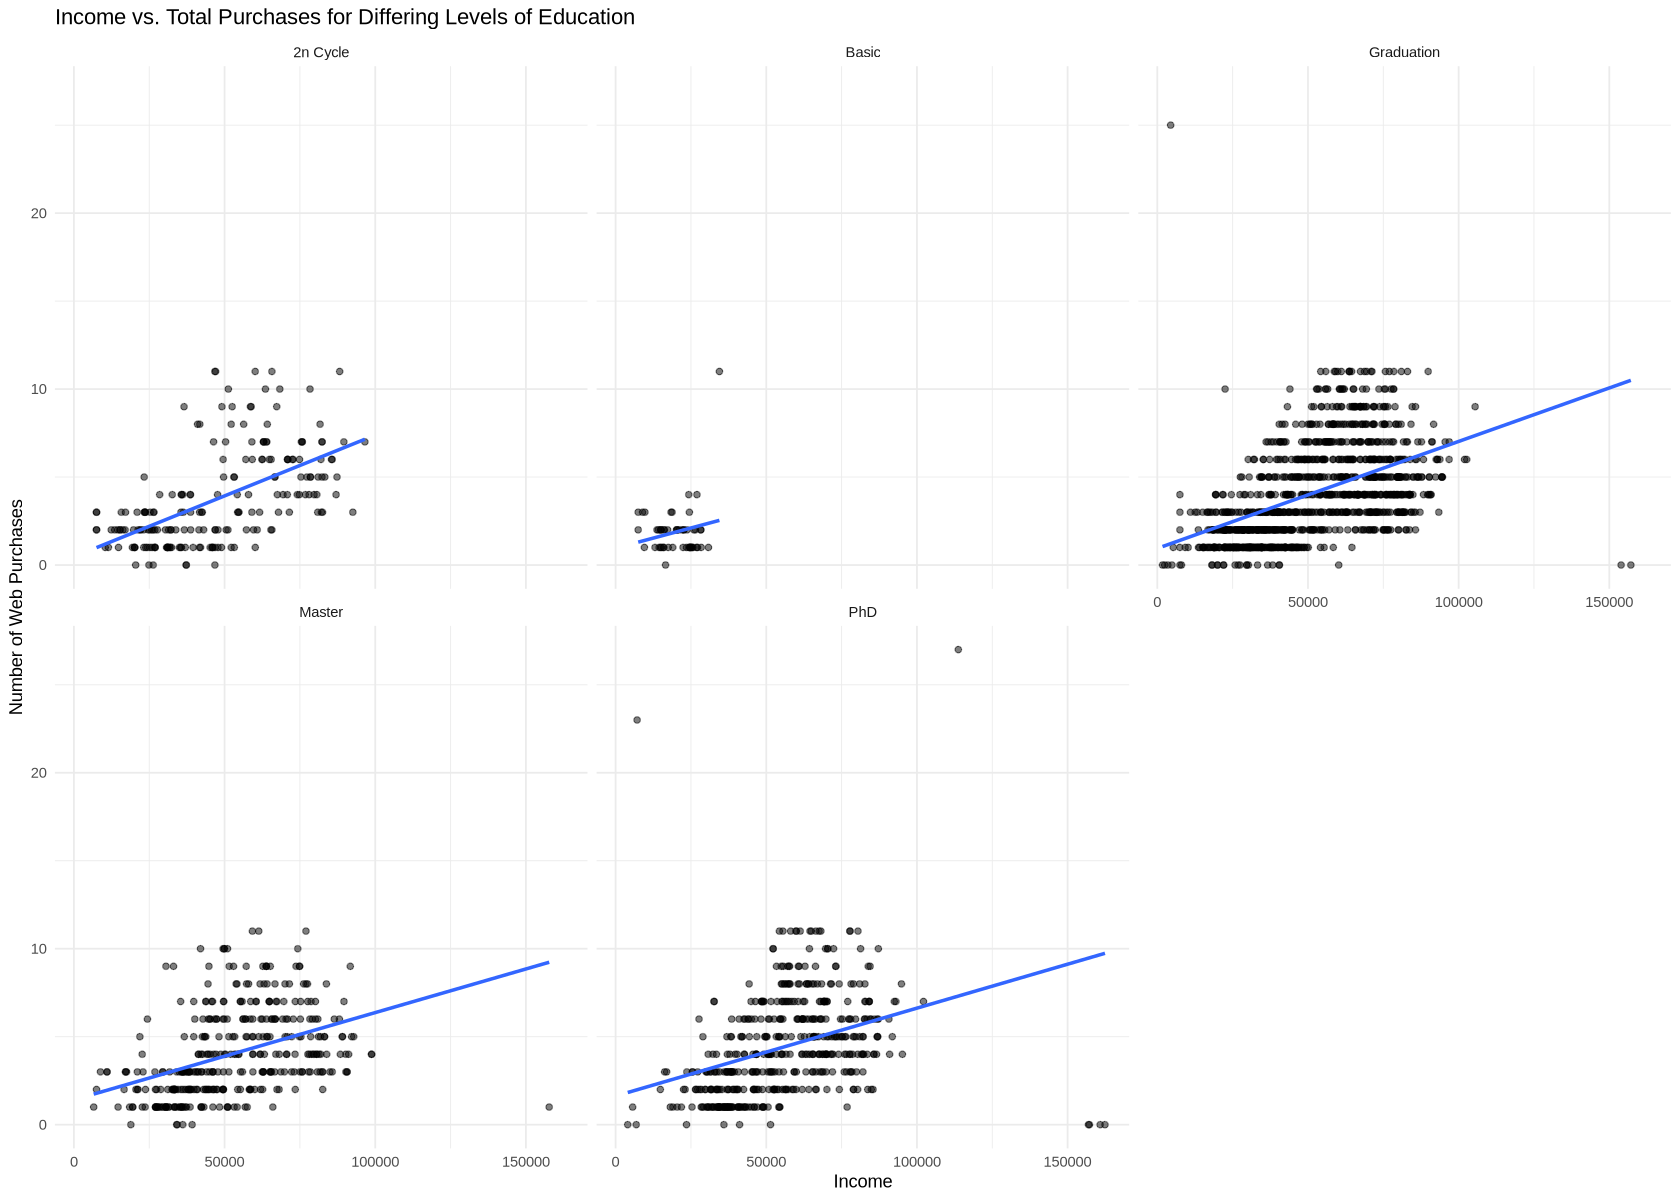

In [9]:
# Scatter Plot: Number of Web Purchases vs Income
options(repr.plot.width = 14, repr.plot.height = 10)

ggplot(data, aes(x = Income, y = NumWebPurchases)) +
  geom_point(alpha = 0.5) +
  geom_smooth(method = "lm", se = FALSE) +
  labs(title = "Income vs. Total Purchases for Differing Levels of Education", x = "Income", y = "Number of Web Purchases") +
  theme_minimal() +
  facet_wrap(~Education)

From the plot, we can tell that there are outliers in our response variable, NumWebPurchases with three total points in total being above 20 (two in the PhD plot, one in the Graduation plot). It also seems like there are outliers in Income greater than 150000. We can remove them and replot our visualization to better understand the relationship between web purchase and income and education levels.

`geom_smooth()` using formula = 'y ~ x'


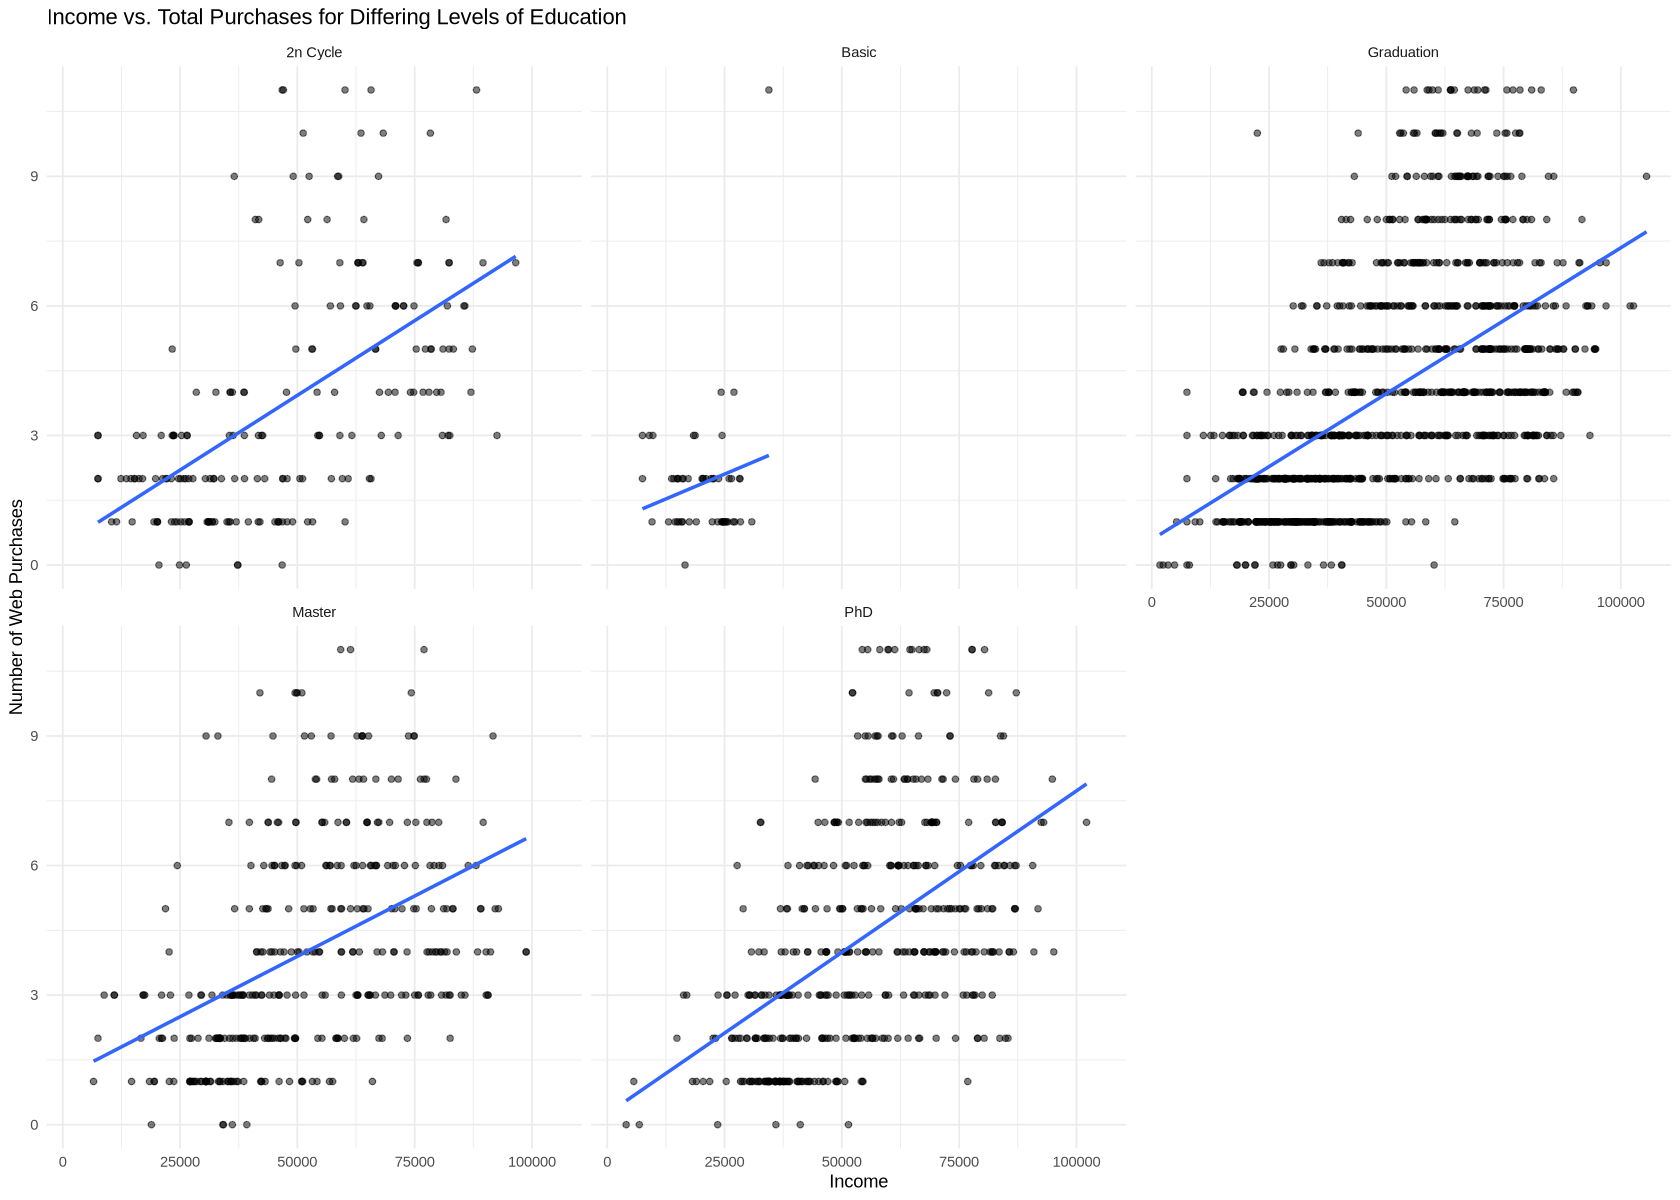

In [10]:
# Remove the outliers in Income and Web Purchases
data <- data[data$Income < 150000, ]
data <- data[data$NumWebPurchases < 20, ]

# Scatter Plot: Number of Web Purchases vs Income
ggplot(data, aes(x = Income, y = NumWebPurchases)) +
  geom_point(alpha = 0.5) +
  geom_smooth(method = "lm", se = FALSE) +
  labs(title = "Income vs. Total Purchases for Differing Levels of Education", x = "Income", y = "Number of Web Purchases") +
  theme_minimal() +
  facet_wrap(~Education)

This plot is important to the analysis of my research question because it compares the continous variable Income, one of my chosen covariates, to the number of web purchases a customer makes (the response), shown for different levels of education that the customer has, which is another one of my covariates. This can be modelled through poisson regression as I am predicting a mean count of purchases. We can see a linear relationship between total number of web purchases and income for most of the categories of education, although it does seem like there is not much association for the PhD education level. The range of income for basic education is way smaller than compared to the other levels of Education.

## Methods and Plan
<!-- Propose one method to address your question of interest using the selected dataset and explain why it was chosen. Just a high-level thinking of what model you are planning to use. 

In your explanation, respond to the following questions:

Why is this method appropriate?
Which assumptions are required, if any, to apply the method selected?
What are the potential limitations or weaknesses of the method selected?
Note 1: you can relax/expand your question(s) from assignment 1, just change them in the corresponding section from previous assignment.
 -->

### Plan
I am planning on using a poisson additive model to model the relationship because it is most simple to interpret and do inference on (compared to a multiplicative interaction model), allowing us to isolate effects of different variables easily. This is appropriate as my target variable is a count variable, meaning I must use a Poisson model. Since I am planning on doing inference, I will need to perform feature selection on my data to understand which variables have the most significant effect on my response, the total number of web purchases a customer makes.

### Assumptions
We assume that our observtions are independent from one another (customer decisions are independent of one another), that the conditional expectation of our response count variable follows a Poisson distribution, and that the mean and variance of the model are identical. 

### Limitations
Modelling this problem through an additive model may not capture interaction effects between different levels of our covariates. 

## Computational Code and Output

<!-- In this section you will implement the method suggested in part (1).  

a) Write a computation code to implement the method proposed in part (1)

b) Write a computational code to implement the method proposed in part (1)

c) Use *only one* visualization or table to report results. 

d) In 3 or 4 sentences give a brief interpretation of the results. If needed, comment on any unexpected result or potential problems with the analysis, and possible ways to address issues encountered. If results are as expected, explain how they address the question of interest. **Do not exceed the 4 sentences limit**.
 -->

First, we begin by splitting our data into training and testing, where we determine which features are significant in the training set, and make a model for inference on the testing set.

In [11]:
# Obtain training and testing data splits from entire dataset
set.seed(1)

# Split 60% training and 40% testing, stratified by the target
data_split = initial_split(data, prop = 0.6, strata = NumWebPurchases)
data_selection = training(data_split)
data_inference = testing(data_split)

In [12]:
# Running stepwise selection on the selection set
full_model = glm(NumWebPurchases ~ ., data = data_selection, family = poisson)

n = nrow(data_selection)
modAIC <- MASS::stepAIC(full_model, direction = "both", k = log(n))

summary(modAIC)

Start:  AIC=5196.86
NumWebPurchases ~ Year_Birth + Education + Marital_Status + Income + 
    Kidhome + Teenhome + Dt_Customer + Recency + MntWines + MntFruits + 
    MntMeatProducts + MntFishProducts + MntSweetProducts + MntGoldProds + 
    NumDealsPurchases + NumCatalogPurchases + NumStorePurchases + 
    NumWebVisitsMonth + AcceptedCmp3 + AcceptedCmp4 + AcceptedCmp5 + 
    AcceptedCmp1 + AcceptedCmp2 + Complain + Response

                      Df Deviance    AIC
- Marital_Status       6   951.62 5165.4
- Education            4   942.81 5171.0
- Year_Birth           1   939.96 5189.7
- AcceptedCmp1         1   939.96 5189.7
- MntWines             1   940.06 5189.8
- AcceptedCmp4         1   940.10 5189.8
- MntFruits            1   940.11 5189.8
- AcceptedCmp5         1   940.43 5190.2
- Complain             1   940.54 5190.3
- AcceptedCmp3         1   940.72 5190.5
- Dt_Customer          1   941.04 5190.8
- Response             1   941.09 5190.8
- MntSweetProducts     1   941.34 519


Call:
glm(formula = NumWebPurchases ~ Income + Kidhome + NumDealsPurchases + 
    NumCatalogPurchases + NumStorePurchases + NumWebVisitsMonth + 
    AcceptedCmp2, family = poisson, data = data_selection)

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -7.207e-01  8.844e-02  -8.149 3.67e-16 ***
Income               1.893e-05  1.232e-06  15.367  < 2e-16 ***
Kidhome             -2.874e-01  3.494e-02  -8.225  < 2e-16 ***
NumDealsPurchases    7.303e-02  7.232e-03  10.099  < 2e-16 ***
NumCatalogPurchases  2.450e-02  6.611e-03   3.705 0.000211 ***
NumStorePurchases    3.850e-02  5.507e-03   6.991 2.74e-12 ***
NumWebVisitsMonth    1.302e-01  8.023e-03  16.233  < 2e-16 ***
AcceptedCmp21       -3.319e-01  1.099e-01  -3.020 0.002525 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 2336.67  on 1321  degrees of freedom
Residual deviance:  977.06  on 1

In [13]:
modAIC$anova

Step,Df,Deviance,Resid. Df,Resid. Dev,AIC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
,NA,NA,1288,939.9294,5196.857
- Marital_Status,6,11.69332326,1294,951.6227,5165.429
- Education,4,2.87223077,1298,954.4949,5139.554
- Year_Birth,1,0.05462838,1299,954.5495,5132.421
- MntFruits,1,0.09244519,1300,954.6420,5125.327
- AcceptedCmp1,1,0.12450899,1301,954.7665,5118.265
- MntWines,1,0.28636660,1302,955.0529,5111.364
- AcceptedCmp4,1,0.21828573,1303,955.2711,5104.395
- AcceptedCmp5,1,0.63949540,1304,955.9106,5097.848


From the output, we see that the significant covariates chosen by the stepwise selection are Income, Kidhome, NumDealsPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, AcceptedCmp2.

Therefore, we can now create an inference model based on these selected covariates using our test/inference set.

In [14]:
# Create poisson model on test set, using the selected features from the training set
model = glm(formula = NumWebPurchases ~ Income + Kidhome + NumDealsPurchases + 
                    NumCatalogPurchases + NumStorePurchases + NumWebVisitsMonth + 
                    AcceptedCmp2, family = poisson,
            data = data_inference
           )

# Exponentiate coefficients in a tidy format
tidy(model, exponentiate = T)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.5384368,1.097783e-01,-5.6394143,1.706296e-08
Income,1.0000200,1.507495e-06,13.2832004,2.897408e-40
Kidhome,0.7668721,4.263187e-02,-6.2262172,4.778316e-10
NumDealsPurchases,1.0549405,8.478378e-03,6.3083270,2.820678e-10
NumCatalogPurchases,1.0072086,8.560999e-03,0.8390132,4.014619e-01
NumStorePurchases,1.0384877,6.786536e-03,5.5647757,2.624899e-08
NumWebVisitsMonth,1.1234275,9.336502e-03,12.4655079,1.151358e-35
AcceptedCmp21,0.7948809,1.309642e-01,-1.7528683,7.962462e-02


<!-- In 3 or 4 sentences give a brief interpretation of the results. If needed, comment on any unexpected result or potential problems with the analysis, and possible ways to address issues encountered. If results are as expected, explain how they address the question of interest.  -->

## Interpretation
We see that not all our variables are significant at a 5% level in the testing inference set (NumCatalogPurchases and AcceptedCmp21), which may mean that the stepwise selection overfit on the training set when it was choosing features. It seems that having kids at home and if a user accepted campaign 2 is associated with a decrease in the total number of web purchases a customer makes, while income, number of items a user purchases (Deals, Catalog, Store), and more website visits per month are positively associated with the response. I am surprised to see that the model chose `AcceptedCmp2` as a covariate because I initially believed that the campaign had nothing to do with the number of website purchases a customer made, but it seems to have enough significance to make it into our final model. Some issues may be that the type of purchases made are correlated with one another, such as NumDealsPurchases and NumStorePurchases, leading to a collinearity issue which could be addressed through using a Ridge model to select the model, but this wouldn't work as we are doing Poisson regression. 

## References

Patel, A. (2021, August 22). Customer personality analysis. Kaggle. https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis/data 